In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import PipelineTS
PipelineTS.__version__

'0.3.4'

In [3]:
from PipelineTS.dataset import BuiltInSeriesData
bs = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [4]:
import pandas as pd
init_data = bs['Messages_Sent']

time_col = 'date'
target_col = 'ta'
lags = 60
n = 40
device = 'cpu'

init_data = init_data[[time_col, target_col]]
init_data[time_col] = pd.to_datetime(init_data[time_col])
init_data = init_data.sort_values(time_col).reset_index(drop=True)

In [5]:
valid_data = init_data.iloc[-n:, :]
data = init_data.iloc[:-n, :]
print("data shape: ", data.shape, ", valid data shape: ", valid_data.shape)
data.tail(5)

data shape:  (562, 2) , valid data shape:  (40, 2)


,date,ta
557,2021-07-11,125957
558,2021-07-12,139012
559,2021-07-13,127014
560,2021-07-14,118241
561,2021-07-15,114358


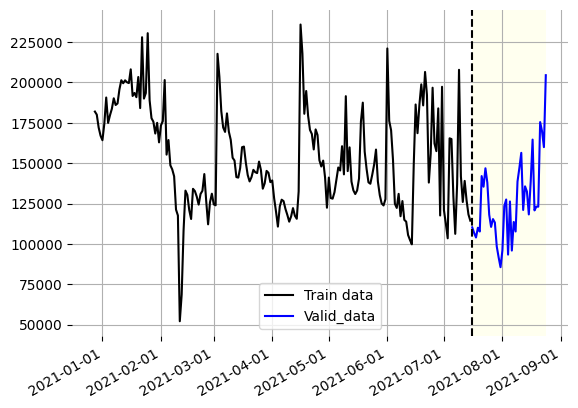

In [6]:
from PipelineTS.plot import plot_data_period
plot_data_period(
    data.iloc[-200:, :], 
    valid_data, 
    time_col=time_col, 
    target_col=target_col, 
    labels=['Train data', 'Valid_data']
)

# PipelineTS

In [7]:
from PipelineTS.pipeline import ModelPipeline, PipelineConfigs

In [8]:
# list all models
ModelPipeline.list_models()

['auto_arima',
 'catboost',
 'lightgbm',
 'xgboost',
 'wide_gbrt',
 'd_linear',
 'n_linear',
 'n_beats',
 'n_hits',
 'tcn',
 'tft',
 'gau',
 'stacking_rnn',
 'time2vec',
 'multi_output_model',
 'multi_step_model',
 'transformer',
 'random_forest',
 'tide',
 'prophet']

In [9]:
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

pipeline_configs = PipelineConfigs([
    ('multi_output_model', {'init_configs': {'verbose': -1}}),
    ('multi_step_model', {'init_configs': {'verbose': -1}}),
    # ('multi_output_model', {
    #     'init_configs': {'estimator': XGBRegressor, 'random_state': 42, 'kwargs':{'verbosity':0}}
    #     }
    # ),
    # ('multi_output_model', {
    #     'init_configs': {'estimator': CatBoostRegressor, 'random_state': 42, 'verbose': False}
    #     }
    # ),
])

,model_name,model_name_with_index,model_configs
0,lightgbm,lightgbm_1,"{'init_configs': {'verbose': -1, 'linear_tree': True}, 'fit_configs': {}, 'predict_configs': {}}"
1,multi_output_model,multi_output_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
2,multi_step_model,multi_step_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
3,xgboost,xgboost_1,"{'init_configs': {'verbosity': 0}, 'fit_configs': {}, 'predict_configs': {}}"


In [10]:
from sklearn.metrics import mean_absolute_error
pipeline = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    configs=pipeline_configs,
    include_init_config_model=False,
    use_standard_scale=False,  # False for MinMaxScaler, True for StandardScaler, None means no data be scaled
    # models=['lightgbm'],  # specifying the model used
    device=device
)

In [11]:
pipeline.fit(data, valid_data=valid_data)

18:39:22 2023-10-17 - PipelineTS - There are a total of 20 models to be trained.
18:39:22 2023-10-17 - PipelineTS - [model  0] fitting and evaluating auto_arima...
18:39:29 2023-10-17 - PipelineTS - [model  1] fitting and evaluating catboost...
18:41:20 2023-10-17 - PipelineTS - [model  2] fitting and evaluating d_linear...
18:41:24 2023-10-17 - PipelineTS - [model  3] fitting and evaluating gau...
18:42:20 2023-10-17 - PipelineTS - [model  4] fitting and evaluating lightgbm_1...
18:42:39 2023-10-17 - PipelineTS - [model  5] fitting and evaluating multi_output_model_1...
18:42:53 2023-10-17 - PipelineTS - [model  6] fitting and evaluating multi_step_model_1...
18:42:53 2023-10-17 - PipelineTS - [model  7] fitting and evaluating n_beats...
18:42:59 2023-10-17 - PipelineTS - [model  8] fitting and evaluating n_hits...
18:43:09 2023-10-17 - PipelineTS - [model  9] fitting and evaluating n_linear...
18:43:12 2023-10-17 - PipelineTS - [model 10] fitting and evaluating prophet...
18:43:12 20

Leaderboard,model,train_cost(s),eval_cost(s),metric
0,n_beats,6.411593,0.009410,19584.698633
1,prophet,0.050692,0.021628,20629.311013
2,time2vec,60.251948,0.001116,22194.084795
3,stacking_rnn,101.858742,0.001796,23117.410328
4,n_hits,9.767269,0.009519,25226.286719
5,tide,6.473400,0.009627,25339.908008
6,auto_arima,6.358462,0.003033,26842.097945
7,catboost,111.410569,0.031003,30901.968223
8,lightgbm_1,18.609590,0.021506,31030.781881
9,gau,56.287772,0.001429,32239.888968


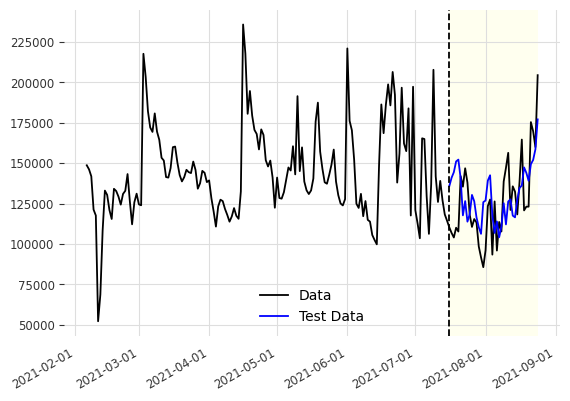

In [12]:
prediction = pipeline.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)

In [13]:
# Gets all configurations for the specified model， default to best model
pipeline.get_models().all_configs

{'model_configs': {'input_chunk_length': 60,
  'output_chunk_length': 60,
  'generic_architecture': False,
  'num_stacks': 30,
  'num_blocks': 1,
  'num_layers': 4,
  'layer_widths': 256,
  'expansion_coefficient_dim': 5,
  'trend_polynomial_degree': 2,
  'dropout': 0.0,
  'activation': 'ReLU',
  'loss_fn': MSELoss(),
  'torch_metrics': None,
  'optimizer_cls': torch.optim.adam.Adam,
  'optimizer_kwargs': None,
  'lr_scheduler_cls': None,
  'lr_scheduler_kwargs': None,
  'use_reversible_instance_norm': False,
  'batch_size': 32,
  'n_epochs': 100,
  'nr_epochs_val_period': 1,
  'add_encoders': None,
  'pl_trainer_kwargs': {'accelerator': 'cpu',
   'enable_progress_bar': False,
   'enable_model_summary': False},
  'random_state': 42},
 'lags': 60,
 'quantile': None,
 'time_col': 'date',
 'target_col': 'ta',
 'enable_progress_bar': False,
 'enable_model_summary': False}

## quantile prediction

In [10]:
from sklearn.metrics import mean_absolute_error

from PipelineTS.pipeline import ModelPipeline

pipeline2 = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    configs=pipeline_configs,
    include_init_config_model=False,
    use_standard_scale=False,
    with_quantile_prediction=True,   # turn on the quantile prediction switch
    device=device,
    # models=['stacking_rnn']
)

In [11]:
pipeline2.fit(data, valid_data)

16:56:11 2023-10-17 - PipelineTS - There are a total of 20 models to be trained.
16:56:11 2023-10-17 - PipelineTS - [model  0] fitting and evaluating auto_arima...
16:56:49 2023-10-17 - PipelineTS - [model  1] fitting and evaluating catboost...
17:07:37 2023-10-17 - PipelineTS - [model  2] fitting and evaluating d_linear...
17:07:57 2023-10-17 - PipelineTS - [model  3] fitting and evaluating gau...
17:14:03 2023-10-17 - PipelineTS - [model  4] fitting and evaluating lightgbm_1...
17:15:47 2023-10-17 - PipelineTS - [model  5] fitting and evaluating multi_output_model_1...
17:17:28 2023-10-17 - PipelineTS - [model  6] fitting and evaluating multi_step_model_1...
17:17:29 2023-10-17 - PipelineTS - [model  7] fitting and evaluating n_beats...
17:18:07 2023-10-17 - PipelineTS - [model  8] fitting and evaluating n_hits...
17:19:02 2023-10-17 - PipelineTS - [model  9] fitting and evaluating n_linear...
17:19:19 2023-10-17 - PipelineTS - [model 10] fitting and evaluating prophet...
17:19:20 20

Leaderboard,model,train_cost(s),eval_cost(s),metric,quantile_acc
0,n_beats,38.035015,0.008499,19584.698633,0.675
1,prophet,0.567123,0.017199,20629.311013,0.925
2,time2vec,391.467610,0.001430,22194.084795,0.425
3,stacking_rnn,670.039764,0.002108,23117.410328,0.150
4,n_hits,54.838336,0.009885,25226.286719,0.525
5,tide,39.363998,0.008917,25339.908008,0.600
6,auto_arima,38.544066,0.002644,26842.097945,0.350
7,catboost,646.998053,0.030895,30901.968223,0.400
8,lightgbm_1,104.213383,0.020173,31030.781881,0.450
9,gau,365.544977,0.001650,32239.888968,0.300


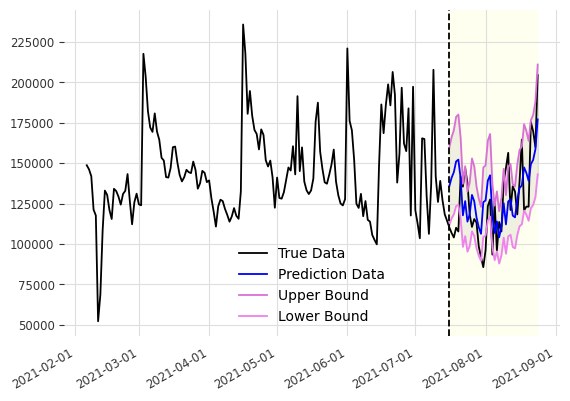

In [12]:
prediction = pipeline2.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)